<a href="https://colab.research.google.com/github/shwets1503/Audio-Classification/blob/master/BDS_project_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==1.15.0

In [2]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
#Importing libraries
import numpy as np 
import pandas as pd

import librosa 
import librosa.display

import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline
matplotlib.style.use('ggplot')

#from python_speech_features import mfcc, logfbank
from scipy.io import wavfile

import os
import shutil
import warnings
warnings.filterwarnings('ignore')

In [0]:
#Reading meta data file
train = pd.read_csv('../content/drive/My Drive/esc50.csv')

In [5]:
train.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


Compute input examples for VGGish from audio waveform

In [6]:
!pip install numpy scipy
!pip install resampy tensorflow six

In [7]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [8]:
!pwd

/content


In [9]:
# Grab the VGGish model
!curl -O https://storage.googleapis.com/audioset/vggish_model.ckpt
!curl -O https://storage.googleapis.com/audioset/vggish_pca_params.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  277M  100  277M    0     0   116M      0  0:00:02  0:00:02 --:--:--  116M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73020  100 73020    0     0  4456k      0 --:--:-- --:--:-- --:--:-- 4456k


In [10]:
# Make sure we got the model data.
!ls

drive		 sample_data		   vggish_pca_params.npz
mel_features.py  vggish_inference_demo.py  vggish_postprocess.py
models		 vggish_input.py	   vggish_slim.py
__pycache__	 vggish_model.ckpt	   vggish_smoke_test.py
README.md	 vggish_params.py	   vggish_train_demo.py


In [11]:
# Verify the location of the AudioSet source files
!ls models/research/audioset/vggish

mel_features.py		  vggish_input.py	 vggish_slim.py
README.md		  vggish_params.py	 vggish_smoke_test.py
vggish_inference_demo.py  vggish_postprocess.py  vggish_train_demo.py


In [0]:
# Copy the source files to the current directory.
!cp models/research/audioset/vggish/* .

In [13]:
!ls

drive		 sample_data		   vggish_pca_params.npz
mel_features.py  vggish_inference_demo.py  vggish_postprocess.py
models		 vggish_input.py	   vggish_slim.py
__pycache__	 vggish_model.ckpt	   vggish_smoke_test.py
README.md	 vggish_params.py	   vggish_train_demo.py


In [14]:
pip install tf_slim

In [15]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [16]:
# Run the test, which also loads all the necessary functions.
from vggish_smoke_test import *

Instructions for updating:
non-resource variables are not supported in the long term

Testing your install of VGGish

Log Mel Spectrogram example:  [[-4.47297436 -4.29457354 -4.14940631 ... -3.9747003  -3.94774997
  -3.78687669]
 [-4.48589533 -4.28825497 -4.139964   ... -3.98368686 -3.94976505
  -3.7951698 ]
 [-4.46158065 -4.29329706 -4.14905953 ... -3.96442484 -3.94895483
  -3.78619839]
 ...
 [-4.46152626 -4.29365061 -4.14848608 ... -3.96638113 -3.95057575
  -3.78538167]
 [-4.46152595 -4.2936572  -4.14848104 ... -3.96640507 -3.95059567
  -3.78537143]
 [-4.46152565 -4.29366386 -4.14847603 ... -3.96642906 -3.95061564
  -3.78536116]]
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
VGGish embedding:  [0.         0.         0.         0.         0.         0.
 0.         0.16137294 0.         0.         0.         0.
 0.         0.         0.      

In [0]:
import vggish_slim
import vggish_params
import vggish_input

def CreateVGGishNetwork(hop_size=0.96):   # Hop size is in seconds.
  """Define VGGish model, load the checkpoint, and return a dictionary that points
  to the different tensors defined by the model.
  """
  vggish_slim.define_vggish_slim()
  checkpoint_path = 'vggish_model.ckpt'
  vggish_params.EXAMPLE_HOP_SECONDS = hop_size
  
  vggish_slim.load_vggish_slim_checkpoint(sess, checkpoint_path)

  features_tensor = sess.graph.get_tensor_by_name(
      vggish_params.INPUT_TENSOR_NAME)
  embedding_tensor = sess.graph.get_tensor_by_name(
      vggish_params.OUTPUT_TENSOR_NAME)

  layers = {'conv1': 'vggish/conv1/Relu',
            'pool1': 'vggish/pool1/MaxPool',
            'conv2': 'vggish/conv2/Relu',
            'pool2': 'vggish/pool2/MaxPool',
            'conv3': 'vggish/conv3/conv3_2/Relu',
            'pool3': 'vggish/pool3/MaxPool',
            'conv4': 'vggish/conv4/conv4_2/Relu',
            'pool4': 'vggish/pool4/MaxPool',
            'fc1': 'vggish/fc1/fc1_2/Relu',
            'fc2': 'vggish/fc2/Relu',
            'embedding': 'vggish/embedding',
            'features': 'vggish/input_features',
         }
  g = tf.get_default_graph()
  for k in layers:
    layers[k] = g.get_tensor_by_name( layers[k] + ':0')
    
  return {'features': features_tensor,
          'embedding': embedding_tensor,
          'layers': layers,
         }

In [0]:
def ProcessWithVGGish(vgg, x, sr):
  '''Run the VGGish model, starting with a sound (x) at sample rate
  (sr). Return a whitened version of the embeddings. Sound must be scaled to be
  floats between -1 and +1.'''

  # Produce a batch of log mel spectrogram examples.
  input_batch = vggish_input.waveform_to_examples(x, sr)
  # print('Log Mel Spectrogram example: ', input_batch[0])

  [embedding_batch] = sess.run([vgg['embedding']],
                               feed_dict={vgg['features']: input_batch})

  # Postprocess the results to produce whitened quantized embeddings.
  pca_params_path = 'vggish_pca_params.npz'

  pproc = vggish_postprocess.Postprocessor(pca_params_path)
  postprocessed_batch = pproc.postprocess(embedding_batch)
  # print('Postprocessed VGGish embedding: ', postprocessed_batch[0])
  return postprocessed_batch[0]

In [19]:
# Test these new functions with the original test.
import tensorflow as tf
tf.reset_default_graph()
sess = tf.Session()

vgg = CreateVGGishNetwork(0.01)

# Generate a 1 kHz sine wave at 44.1 kHz (we use a high sampling rate
# to test resampling to 16 kHz during feature extraction).
num_secs = 3
freq = 1000
sr = 44100
#t = np.linspace(0, num_secs, int(num_secs * sr))
#x = np.sin(2 * np.pi * freq * t)  # Unit amplitude input signal
from scipy.io.wavfile import read
a = read('/content/drive/My Drive/audio/1-137296-A-16.wav')
x = np.array(a[1],dtype=float)

postprocessed_batch = ProcessWithVGGish(vgg, x, sr)

# print('Postprocessed VGGish embedding: ', postprocessed_batch[0])
expected_postprocessed_mean = 123.0
expected_postprocessed_std = 75.0
np.testing.assert_allclose(
    [np.mean(postprocessed_batch), np.std(postprocessed_batch)],
    [expected_postprocessed_mean, expected_postprocessed_std],
    rtol=rel_error)

INFO:tensorflow:Restoring parameters from vggish_model.ckpt


In [0]:
def EmbeddingsFromVGGish(vgg, x, sr):
  '''Run the VGGish model, starting with a sound (x) at sample rate
  (sr). Return a dictionary of embeddings from the different layers
  of the model.'''
  # Produce a batch of log mel spectrogram examples.
  input_batch = vggish_input.waveform_to_examples(x, sr)
  # print('Log Mel Spectrogram example: ', input_batch[0])

  layer_names = vgg['layers'].keys()
  tensors = [vgg['layers'][k] for k in layer_names]
  
  results = sess.run(tensors,
                     feed_dict={vgg['features']: input_batch})

  resdict = {}
  for i, k in enumerate(layer_names):
    resdict[k] = results[i]
    
  return resdict

In [0]:
resdict = EmbeddingsFromVGGish(vgg, x, sr)

In [22]:
for k in resdict:
  print(k, resdict[k].shape)

conv1 (403, 96, 64, 64)
pool1 (403, 48, 32, 64)
conv2 (403, 48, 32, 128)
pool2 (403, 24, 16, 128)
conv3 (403, 24, 16, 256)
pool3 (403, 12, 8, 256)
conv4 (403, 12, 8, 512)
pool4 (403, 6, 4, 512)
fc1 (403, 4096)
fc2 (403, 128)
embedding (403, 128)
features (403, 96, 64)


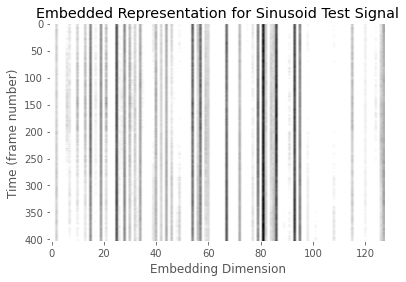

In [23]:
import matplotlib.pyplot as plt
plt.imshow(resdict['embedding'], 
           aspect='auto', cmap='binary')
plt.xlabel('Embedding Dimension')
plt.ylabel('Time (frame number)')
plt.title('Embedded Representation for Sinusoid Test Signal')
plt.grid(False);